In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras import Model

from sklearn.metrics import accuracy_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import os
from sklearn.metrics import confusion_matrix, classification_report

In [99]:
import os
import numpy as np
from PIL import Image

FACES_DIR = "faces"
SMILE_LIST = "lists/SMILE_list.txt"
NONSMILE_LIST = "lists/NON-SMILE_list.txt"


with open(SMILE_LIST, "r") as f:
    smile_files = [line.strip() for line in f if line.strip() != ""]

with open(NONSMILE_LIST, "r") as f:
    nonsmile_files = [line.strip() for line in f if line.strip() != ""]

print("Ejemplos SMILE_list:", smile_files[:5])
print("Ejemplos NONSMILE_list:", nonsmile_files[:5])


def safe_load(path):
    try:
        return np.array(Image.open(path)) / 255.0
    except Exception as e:
        print(f"⚠️ Error leyendo {path}: {e}")
        return None


X = []
y = []

for fname in smile_files:
    ppm_name = fname.replace(".jpg", ".ppm")  
    path = os.path.join(FACES_DIR, ppm_name)
    if os.path.exists(path):
        img = safe_load(path)
        if img is not None:
            X.append(img)
            y.append("smile")
    else:
        print("No existe:", path)

for fname in nonsmile_files:
    ppm_name = fname.replace(".jpg", ".ppm")  
    path = os.path.join(FACES_DIR, ppm_name)
    if os.path.exists(path):
        img = safe_load(path)
        if img is not None:
            X.append(img)
            y.append("non-smile")
    else:
        print("No existe:", path)

features = np.array(X)
labels = np.array(y)

print("features shape:", features.shape)
print("labels shape:", labels.shape)

Ejemplos SMILE_list: ['James_Jones_0001.jpg', 'James_Kelly_0009.jpg', 'James_McPherson_0001.jpg', 'James_Watt_0001.jpg', 'Jamie_Carey_0001.jpg']
Ejemplos NONSMILE_list: ['Aaron_Eckhart_0001.jpg', 'Aaron_Patterson_0001.jpg', 'Abdel_Nasser_Assidi_0002.jpg', 'Abdoulaye_Wade_0004.jpg', 'Abdulaziz_Kamilov_0001.jpg']
No existe: faces\listt.txt
No existe: faces\SMILE_list.txt
features shape: (1203, 64, 64, 3)
labels shape: (1203,)


In [100]:
print("Ejemplos SMILE_list:", smile_files[:5])
print("Ejemplos NONSMILE_list:", nonsmile_files[:5])


Ejemplos SMILE_list: ['James_Jones_0001.jpg', 'James_Kelly_0009.jpg', 'James_McPherson_0001.jpg', 'James_Watt_0001.jpg', 'Jamie_Carey_0001.jpg']
Ejemplos NONSMILE_list: ['Aaron_Eckhart_0001.jpg', 'Aaron_Patterson_0001.jpg', 'Abdel_Nasser_Assidi_0002.jpg', 'Abdoulaye_Wade_0004.jpg', 'Abdulaziz_Kamilov_0001.jpg']


In [101]:
print(labels.shape)
print(features.shape)

(1203,)
(1203, 64, 64, 3)


In [102]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

labels_int = le.fit_transform(labels.ravel())

In [103]:
print(labels[0])
print(labels_int[0])

smile
1


In [104]:
labels = tf.keras.utils.to_categorical(labels_int, num_classes = 2)

In [105]:
labels[0:10,:]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [106]:
normal_indices = np.where(labels_int == 1)[0] #Smile
abnormal_indices = np.where(labels_int == 0)[0] #Non-Smile  

In [107]:
normal_indices.shape

(600,)

In [108]:
abnormal_indices.shape

(603,)

In [109]:
features_normal = features[normal_indices]
features_abnormal = features[abnormal_indices]

labels_normal = labels[normal_indices]
labels_abnormal = labels[abnormal_indices]

In [110]:
features_normal.shape

(600, 64, 64, 3)

In [111]:
features_normal_flat   = features_normal.reshape(len(features_normal), -1)
features_abnormal_flat = features_abnormal.reshape(len(features_abnormal), -1)

input_dim = features_normal_flat.shape[1]
print("Dimensión de entrada (input_dim):", input_dim)

Dimensión de entrada (input_dim): 12288


In [112]:
from sklearn.model_selection import train_test_split
 
train_features, test_features_norm, train_labels, test_labels_norm = train_test_split(
    features_normal_flat,
    labels_normal,
    train_size=0.80,
    random_state=1234,
)

In [113]:
test_features = np.concatenate((test_features_norm, features_abnormal_flat), axis=0)
test_labels   = np.concatenate((test_labels_norm,  labels_abnormal),axis=0)

In [114]:
model = keras.Sequential([
    keras.layers.Dense(units=32, input_shape=(input_dim,), activation=tf.nn.relu),
    keras.layers.Dense(units=16, activation=tf.nn.relu),
    keras.layers.Dense(units=8,  activation=tf.nn.relu),   
    keras.layers.Dense(units=16, activation=tf.nn.relu),
    keras.layers.Dense(units=32, activation=tf.nn.relu),
    keras.layers.Dense(units=input_dim, activation="linear")  
])

c:\Users\danis\anaconda3\envs\mv-tec\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [115]:
print(model.summary())

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 32)             │       393,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 12288)          │       405,504 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 800,104 (3.05 MB)

 Trainable params: 800,104 (3.05 MB)

 Non-trainable params: 0 (0.00 B)

None


In [116]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

model.compile(
    optimizer=optimizer,
    loss="mse",
    metrics=['mse']
)

history = model.fit(
    train_features,
    train_features,        
    epochs=1000,
    validation_split=0.1,
    batch_size=32,
    verbose=1
)

Epoch 1/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.2940 - mse: 0.2940 - val_loss: 0.2803 - val_mse: 0.2803
Epoch 2/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2940 - mse: 0.2940 - val_loss: 0.2802 - val_mse: 0.2802
Epoch 3/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2940 - mse: 0.2940 - val_loss: 0.2802 - val_mse: 0.2802
Epoch 4/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2939 - mse: 0.2939 - val_loss: 0.2802 - val_mse: 0.2802
Epoch 5/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2939 - mse: 0.2939 - val_loss: 0.2801 - val_mse: 0.2801
Epoch 6/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2939 - mse: 0.2939 - val_loss: 0.2801 - val_mse: 0.2801
Epoch 7/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2939 - mse: 0.2939 - val_loss: 0.2801 - val_mse: 0.2801
Epoch 8/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2938 - mse: 0.2938 - val_loss: 0.2801 - val_mse: 0.2801
Epoch 9/1000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - l

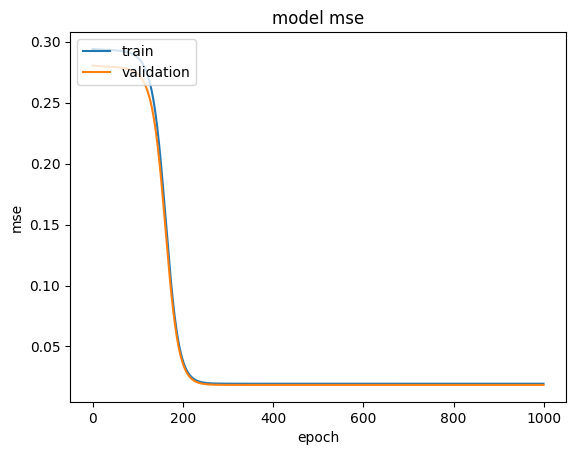

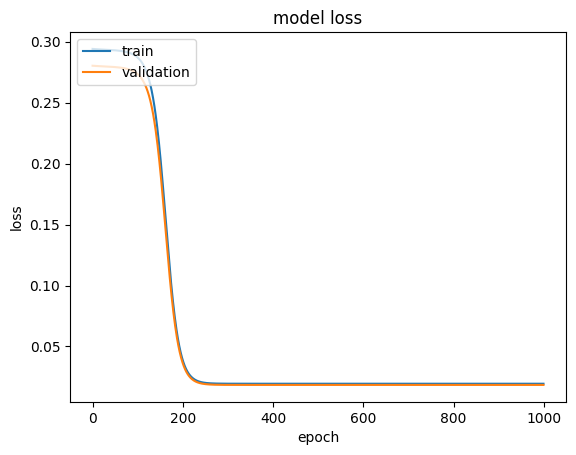

In [117]:
# Plot accuracy and loss curves

import matplotlib.pyplot as plt
%matplotlib inline
# summarize history for accuracy
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_mse'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [118]:
model.evaluate(train_features, train_features)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0194 - mse: 0.0194 


[0.019353492185473442, 0.019353492185473442]

In [119]:
model.evaluate(test_features, test_features)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0206 - mse: 0.0206 


[0.02060321532189846, 0.02060321532189846]

In [120]:
predictions = model.predict(train_features)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [121]:
predictions[0:5]

array([[0.46029562, 0.3564158 , 0.27298966, ..., 0.42068523, 0.34929544,
        0.2796373 ],
       [0.42598355, 0.3291678 , 0.25152612, ..., 0.38892162, 0.31729546,
        0.2611272 ],
       [0.4109206 , 0.3160758 , 0.2420664 , ..., 0.37539157, 0.30775544,
        0.2510146 ],
       [0.3824574 , 0.29558772, 0.2262697 , ..., 0.34975296, 0.28507558,
        0.23462352],
       [0.3911458 , 0.30123773, 0.23078273, ..., 0.3574408 , 0.29216447,
        0.23927656]], dtype=float32)

In [122]:
def squared_errors(predictions, gt):
  squaredErrors = []

  for i in range(len(predictions)):
    squaredErrors.append(sum((predictions[i] - gt[i])**2))

  return squaredErrors

In [123]:
errors_train_normal = squared_errors(predictions, train_features)

print(np.mean(errors_train_normal))

quantiles = np.quantile(errors_train_normal, [0.0, 0.25, 0.50, 0.75, .90, 1.0])
print(quantiles)

237.81570449361237
[ 43.29798406 154.78894881 211.30609429 297.56107304 387.5593226
 701.27722469]


In [140]:
threshold = 300
print("Threshold:", threshold)

Threshold: 300


In [141]:
test_predictions = model.predict(test_features)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [142]:
test_squared_errors = squared_errors(test_predictions, test_features)

In [143]:
test_predictions = np.where(np.array(test_squared_errors) > threshold, 0, 1)

print(test_squared_errors[0:5])
print(test_predictions[0:5])

[np.float64(114.34712164668018), np.float64(218.88317120199594), np.float64(83.98134738426536), np.float64(138.7581464180361), np.float64(365.79366597499694)]
[1 1 1 1 0]


In [144]:
predictions_str = le.inverse_transform(test_predictions)

In [145]:
gt_int = np.argmax(test_labels, axis=1)
gt_str = le.inverse_transform(gt_int)

In [146]:
pd.crosstab(gt_str, predictions_str, rownames=['True labels'], colnames=['Predicted labels'])

Predicted labels,non-smile,smile
True labels,,
non-smile,177,426
smile,36,84


In [147]:
print("\nClassification report:")
print(classification_report(gt_str, predictions_str, target_names=['non-smile','smile']))


Classification report:
              precision    recall  f1-score   support

   non-smile       0.83      0.29      0.43       603
       smile       0.16      0.70      0.27       120

    accuracy                           0.36       723
   macro avg       0.50      0.50      0.35       723
weighted avg       0.72      0.36      0.41       723

